In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import argparse
import h5py
from scipy.stats import t as student_t
from statsmodels.stats import multitest as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# IDP_df = pd.read_pickle('male_IDP_prototype.pkl')
# vars_df = pd.read_pickle('male_vars_prototype.pkl')

IDP_df = pd.read_pickle('male_IDP_ensemble_vars_select_testset.pkl')
vars_df = pd.read_pickle('male_vars_ensembles_vars_select_testset.pkl')

IDP_names = np.loadtxt("IDP_names.txt", dtype=str, delimiter='\n')
IDP_categories = np.loadtxt("IDP_categories.txt", dtype=str, delimiter='\n')
with open('varsHeader.txt') as f:
    varsHeader = f.readlines()
    varsHeader = [l.strip('\n\r') for l in varsHeader]
    varsHeader = np.array(varsHeader)
vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')

In [3]:
vars_df.head()

,modality,bonf,fdr,dataframe
0,Cluster1,5.508287,4.193112,idx ...
1,Cluster2,5.508287,4.303569,idx ...
2,Cluster3,5.508287,4.160820,idx ...
3,Cluster4,5.508287,5.412181,idx ...
4,Cluster5,5.508287,4.013103,idx ...


In [4]:
vars_df.iloc[0].dataframe.head()

,idx,names,Categories,pearson_r,t_test_statistic,p_values_corrected,p_values,abs_pearson_r,log_p_values,log_p_values_corrected
0,0,Ethnic background (0.0),Ethnic Background,0.011859,0.553124,1.0,0.580235,0.011859,0.236396,-0.0
1,1,Ethnic background (1.0),Ethnic Background,-0.005591,0.110282,1.0,0.912242,0.005591,0.039890,-0.0
2,2,Ethnic background (2.0),Ethnic Background,0.047263,1.195127,1.0,0.232481,0.047263,0.633612,-0.0
3,3,Genotype measurement batch (0.0),Genetic Markers,-0.017765,0.820999,1.0,0.411738,0.017765,0.385379,-0.0
4,4,Heterozygosity (0.0),Genetic Markers,0.004809,0.222225,1.0,0.824160,0.004809,0.083988,-0.0


In [5]:
vars_over_bThr_list = []

for idx in range(len(vars_df)):
    df = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf
    vars_over_bThr = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_bThr:
        vars_over_bThr_list.append(var)

In [6]:
print("Number of unique vars across all modalities: ", len(set(vars_over_bThr_list)))

Number of unique vars across all modalities:  16


In [7]:
unique_vars_over_bTHr = list(set(vars_over_bThr_list))

In [8]:
unique_vars_over_bThr_categories = []

for var in unique_vars_over_bTHr:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars_over_bThr_categories.append(category)

In [9]:
sorted(unique_vars_over_bTHr)

['Alcohol (2.0)',
 'Alcohol intake frequency. (0.0)',
 'Alcohol intake frequency. (2.0)',
 'Central systolic blood pressure during PWA (2.0)',
 'Diagnoses - secondary ICD10 (I10 - I10 Essential (primary) hypertension)',
 'End systolic pressure during PWA (2.0)',
 'End systolic pressure during PWA (2.1)',
 'Frequency of drinking alcohol (0.0)',
 'IGF-1 (0.0)',
 'Main speciality of consultant (recoded) (0.2)',
 'Mean arterial pressure during PWA (2.0)',
 'Mean arterial pressure during PWA (2.1)',
 'Smoking status (0.0)',
 'Smoking status (2.0)',
 'Systolic brachial blood pressure (2.0)',
 'Treatment/medication code (1140860806 - ramipril)']

In [10]:
modalities = []
pearson_rs_list = []
for var in unique_vars_over_bTHr:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df)):
        df = vars_df.iloc[idx].dataframe
        modality = vars_df.iloc[idx].modality
        bThr = vars_df.iloc[idx].bonf
        df = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False)
        vars_over_bThr = df.names.to_list()
        pearson_r_over_bThr = df.pearson_r.to_list()
        if var in vars_over_bThr:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_bThr[vars_over_bThr.index(var)])
    modalities.append(modalities_with_var)
    pearson_rs_list.append(pearsonRs_with_var)

In [11]:
len(modalities)

16

In [12]:
df_vars_over_bThr = pd.DataFrame.from_dict({
    'names': unique_vars_over_bTHr,
    'Categories': unique_vars_over_bThr_categories,
    'modalities': modalities,
    'pearson_r': pearson_rs_list
})

In [13]:
df_vars_over_bThr.head()

,names,Categories,modalities,pearson_r
0,Smoking status (0.0),Tobacco,"[Cluster3, Cluster5]","[0.10255690106898259, 0.11876467190331866]"
1,Diagnoses - secondary ICD10 (I10 - I10 Essenti...,Medical History,[Cluster3],[0.10732446091133985]
2,Main speciality of consultant (recoded) (0.2),Medical History,[Cluster1],[-0.1696354044996265]
3,Treatment/medication code (1140860806 - ramipril),Medical History,[Cluster4],[0.11384008548109847]
4,Mean arterial pressure during PWA (2.1),Cardiac & Circulartory Measurements,[Cluster3],[0.11089587757566795]


In [14]:
set(df_vars_over_bThr.Categories.to_list())

{'Alcohol',
 'Blood Assays',
 'Cardiac & Circulartory Measurements',
 'Diet',
 'Medical History',
 'Tobacco'}

In [15]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        for i, mod in enumerate(mods[0]):
            print('   -> {} ({:.3f})'.format(mod, prs[0][i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.117)
   -> Cluster3 (0.101)
   -> Cluster5 (0.102)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster1 (0.129)
   -> Cluster2 (0.101)
   -> Cluster3 (0.105)
   -> Cluster5 (0.110)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster1 (0.164)
   -> Cluster5 (0.128)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> Cluster1 (-0.109)
   -> Cluster2 (-0.137)
   -> Cluster3 (-0.108)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Central systolic blood pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.127)
Var: End systolic pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.116)
Var: End systolic pressure during PWA (2.1)
   Modalities:
   -> Cluster3 (0.110)
Var: Mean arterial pressure during 

In [16]:
sorted(prs[0], reverse=True)

[0.10041949076127515]

In [17]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        for i, mod in enumerate(mods):
            print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.117)
   -> Cluster5 (0.102)
   -> Cluster3 (0.101)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster1 (0.129)
   -> Cluster5 (0.110)
   -> Cluster3 (0.105)
   -> Cluster2 (0.101)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster1 (0.164)
   -> Cluster5 (0.128)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> Cluster2 (-0.137)
   -> Cluster1 (-0.109)
   -> Cluster3 (-0.108)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Central systolic blood pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.127)
Var: End systolic pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.116)
Var: End systolic pressure during PWA (2.1)
   Modalities:
   -> Cluster3 (0.110)
Var: Mean arterial pressure during 

In [18]:
variance_threshold = 0.1

for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        if prs[0] >= variance_threshold:
            print('Var: {}'.format(name))
            print('   Modalities:')
            for i, mod in enumerate(mods):
                if prs[i] >= variance_threshold:
                    print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.117)
   -> Cluster5 (0.102)
   -> Cluster3 (0.101)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster1 (0.129)
   -> Cluster5 (0.110)
   -> Cluster3 (0.105)
   -> Cluster2 (0.101)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster1 (0.164)
   -> Cluster5 (0.128)


Category: Blood Assays
------------------------------------------------


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Central systolic blood pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.127)
Var: End systolic pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.116)
Var: End systolic pressure during PWA (2.1)
   Modalities:
   -> Cluster3 (0.110)
Var: Mean arterial pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.116)
Var: Mean arterial pressure during PWA (2.1)
   Modaliti

In [19]:
mods

('Cluster5',)

In [20]:
counter = 0
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()[0]
        if 'ElasticNetFull' in mods or 'ElasticNetFull' in mods or 'ElasticNetFull' in mods:
            print('Var: {}'.format(name))
            counter += 1
        else:
            pass
    print('\n')
    
print("There are {} vars independent from the conventional modalities".format(counter))

Category: Alcohol
------------------------------------------------


Category: Blood Assays
------------------------------------------------


Category: Cardiac & Circulartory Measurements
------------------------------------------------


Category: Diet
------------------------------------------------


Category: Medical History
------------------------------------------------


Category: Tobacco
------------------------------------------------


There are 0 vars independent from the conventional modalities


In [21]:
# IDP_df0 = pd.read_pickle('male_IDP_testB.pkl')
vars_df0 = pd.read_pickle('male_vars_testB.pkl')

In [22]:
vars0_over_bThr_list = []

for idx in range(len(vars_df0)):
    df = vars_df0.iloc[idx].dataframe
    bThr = vars_df0.iloc[idx].bonf
    vars_over_bThr = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_bThr:
        vars0_over_bThr_list.append(var)

In [23]:
print("Number of unique vars across all modalities: ", len(set(vars0_over_bThr_list)))

Number of unique vars across all modalities:  42


In [24]:
unique_vars0_over_bTHr = list(set(vars0_over_bThr_list))
unique_vars0_over_bThr_categories = []

for var in unique_vars0_over_bTHr:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars0_over_bThr_categories.append(category)
    
modalities0 = []
pearson_rs_list0 = []
for var in unique_vars0_over_bTHr:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df0)):
        df = vars_df0.iloc[idx].dataframe
        modality = vars_df0.iloc[idx].modality
        bThr = vars_df0.iloc[idx].bonf
        df = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False)
        vars_over_bThr = df.names.to_list()
        pearson_r_over_bThr = df.pearson_r.to_list()
        if var in vars_over_bThr:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_bThr[vars_over_bThr.index(var)])
    modalities0.append(modalities_with_var)
    pearson_rs_list0.append(pearsonRs_with_var)

In [25]:
df_vars0_over_bThr = pd.DataFrame.from_dict({
    'names': unique_vars0_over_bTHr,
    'Categories': unique_vars0_over_bThr_categories,
    'modalities': modalities0,
    'pearson_r': pearson_rs_list0
})

In [26]:
df_vars0_over_bThr[df_vars0_over_bThr.names=='Alcohol intake frequency. (2.0)']

,names,Categories,modalities,pearson_r
15,Alcohol intake frequency. (2.0),Alcohol,"[tbss_FA_s, tbss_L1_s, tbss_OD_s, tbss_ICVF, t...","[0.1081203879296585, 0.10909079636749124, 0.10..."


In [27]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        mods0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].modalities.to_list()
        prs0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        for i, mod in enumerate(mods):
            print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
        
        if len(mods0) == 0:
            print('======== ATTENTION! NEW VAR ! ==========')
        else:
            prs_abs0 = np.abs(prs0).tolist()
            _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
            _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
        

#         for i, mod in enumerate(mods0):
#             print('   -> {} ({:.3f})'.format(mod, prs0[i]))
            print('   -> {} ({:.3f})'.format(mods0[0], prs0[0]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.117)
   -> Cluster5 (0.102)
   -> Cluster3 (0.101)
   -> tbss_MD (0.107)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster1 (0.129)
   -> Cluster5 (0.110)
   -> Cluster3 (0.105)
   -> Cluster2 (0.101)
   -> tbss_L1 (0.110)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster1 (0.164)
   -> Cluster5 (0.128)
   -> tbss_FA_s (0.141)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> Cluster2 (-0.137)
   -> Cluster1 (-0.109)
   -> Cluster3 (-0.108)
   -> tbss_OD (-0.118)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Central systolic blood pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.127)
   -> T2_lesions (0.122)
Var: End systolic pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.116)
 

In [28]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        mods0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].modalities.to_list()
        prs0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
#         for i, mod in enumerate(mods):
#             print('   -> {} ({:.3f})'.format(mod, prs[i]))
        print('   -> {} ({:.3f})'.format(mods[0], prs[0]))
        
        
        if len(mods0) == 0:
            print('======== ATTENTION! NEW VAR ! ==========')
        else:
            prs_abs0 = np.abs(prs0).tolist()
            _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
            _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
        

#         for i, mod in enumerate(mods0):
#             print('   -> {} ({:.3f})'.format(mod, prs0[i]))
            print('   -> {} ({:.3f})'.format(mods0[0], prs0[0]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.117)
   -> tbss_MD (0.107)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster1 (0.129)
   -> tbss_L1 (0.110)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster1 (0.164)
   -> tbss_FA_s (0.141)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> Cluster2 (-0.137)
   -> tbss_OD (-0.118)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Central systolic blood pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.127)
   -> T2_lesions (0.122)
Var: End systolic pressure during PWA (2.0)
   Modalities:
   -> Cluster3 (0.116)
   -> T2_lesions (0.118)
Var: End systolic pressure during PWA (2.1)
   Modalities:
   -> Cluster3 (0.110)
   -> T2_lesions (0.114)
Var: Mean arterial pressure during PWA (2.0)
   Modalit

In [29]:
prs_diffs = []
higher = 0
lower = 0

for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        mods0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].modalities.to_list()
        prs0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        if len(mods)!=0 and len(mods0)!=0:
            prs_abs = np.abs(prs).tolist()
            _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
            _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
            prs_abs0 = np.abs(prs0).tolist()
            _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
            _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
            
            prs_diff = abs(prs[0]) - abs(prs0[0])
            
            print('Diff=', prs_diff)
            prs_diffs.append(prs_diff)
            
            if prs_diff >= 0:
                higher += 1
            else:
                lower += 1
        
#         for i, mod in enumerate(mods):
#             print('   -> {} ({:.3f})'.format(mod, prs[i]))
#         print('   -> {} ({:.3f})'.format(mods[0], prs[0]))
        
        
#         if len(mods0) == 0:
#             print('======== ATTENTION! NEW VAR ! ==========')
#         else:
#             prs_abs0 = np.abs(prs0).tolist()
#             _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
#             _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
        

# #         for i, mod in enumerate(mods0):
# #             print('   -> {} ({:.3f})'.format(mod, prs0[i]))
#             print('   -> {} ({:.3f})'.format(mods0[0], prs0[0]))
        
    print('\n')
    
print(np.mean(prs_diffs))
print(higher)
print(lower)

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
Diff= 0.010828919920823299
Var: Alcohol intake frequency. (2.0)
   Modalities:
Diff= 0.01814615648733979
Var: Frequency of drinking alcohol (0.0)
   Modalities:
Diff= 0.023212623930287835


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
Diff= 0.01913826019393612


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Central systolic blood pressure during PWA (2.0)
   Modalities:
Diff= 0.004973924396696555
Var: End systolic pressure during PWA (2.0)
   Modalities:
Diff= -0.002013030255865425
Var: End systolic pressure during PWA (2.1)
   Modalities:
Diff= -0.004622855833853343
Var: Mean arterial pressure during PWA (2.0)
   Modalities:
Diff= 0.005518274889202243
Var: Mean arterial pressure during PWA (2.1)
   Modalities:
Diff= 0.00408396373036167
Var: Systolic brachia

In [30]:
unique_vars_categories = list(set(vars_categories))
unique_vars_counters = []
for unique_category in unique_vars_categories:
    counter = 0
    for category in vars_categories:
        if unique_category == category:
            counter += 1
    unique_vars_counters.append(counter)
categories_of_interest = list(set(df_vars_over_bThr.Categories.to_list()))
categories_of_interest.sort()

counters_of_interest = []
for cat in categories_of_interest:
    idx = unique_vars_categories.index(cat)
    counters_of_interest.append(unique_vars_counters[idx])


In [31]:
modalities = []
counters = []


for idx in range(len(vars_df.modality)):
    
    modality = vars_df.iloc[idx].modality

    df_of_interest = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf

    counter = []

    for category in categories_of_interest:
        counter.append(len(df_of_interest[(df_of_interest.Categories==category) & (df_of_interest.log_p_values>=bThr)]))
    
    modalities.append(modality)
    counters.append(counter)

In [32]:
unique_vars_categories2, unique_vars_counters2 = zip(*sorted(zip(unique_vars_categories, unique_vars_counters)))

In [33]:
counters = np.array(counters)
dct = {}
dct['modality'] = modalities
for idx, cat in enumerate(categories_of_interest):
    dct[cat] = counters[:, idx] / counters_of_interest[idx]
    
df_dct = pd.DataFrame.from_dict(dct)
df_dct.replace([np.inf, -np.inf], np.nan, inplace=True)

In [34]:
df_dct = pd.melt(df_dct, id_vars="modality", var_name="var_name", value_name="var_hits")

/Users/aroibu_admin/agemapper/env/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Alcohol'),
  Text(1, 0, 'Blood Assays'),
  Text(2, 0, 'Cardiac & Circulartory Measurements'),
  Text(3, 0, 'Diet'),
  Text(4, 0, 'Medical History'),
  Text(5, 0, 'Tobacco')])

<Figure size 1152x691.2 with 0 Axes>

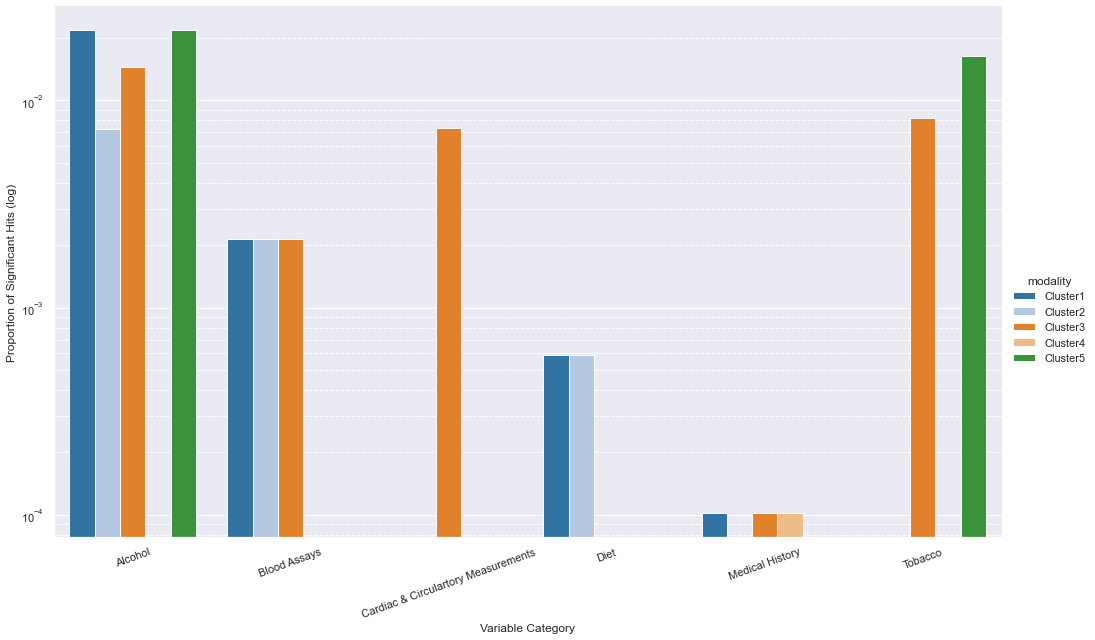

In [35]:
plt.figure(figsize=(16, 9.6))
sns.factorplot(x='var_name', y='var_hits', hue='modality', data=df_dct, kind='bar', height=8, 
               aspect=1.75, log=True, palette='tab20')
plt.xlabel('Variable Category')
plt.ylabel('Proportion of Significant Hits (log)')
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=20)